### 0. DESCRIPTION

Hi! I concieved of the ___Under the Hood___ series of Kaggle kernels as part of my machine learning training. The idea is to implement popular machine learning models in Python/Numpy and compare their performance against a benchmark, i.e. a similar model in the machine learning libraries like Scikit-learn or Keras. I agree with Andrej Karpathy who wrote in his [blog](http://karpathy.github.io/neuralnets/) : "...everything became much clearer when I started writing code." 

This kernel is dedicated to the ___Dense Neural Network___ (aka fully connected network) applied to the ___Titanic___ dataset. We have the following __challenges__: 
for an adjustable network architecture implement model initialization, forward propagation with ReLU activation in the hidden layers and Sigmoid activation in the output layer, cross-entropy cost function with L2 regularization, backpropagation and parameters update with stochastic gradient descent and Adam optimizer, and finally prediction of binary labels after learning the model for various hyperparameters.
 
Any feedback or ideas are welcome.

In [57]:
import numpy as np                # to build the model
import pandas as pd               # to load, review and wrangle data
import matplotlib.pyplot as plt   # to plot the learning curve
from keras.models import Sequential   # to compare with my model
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2

%matplotlib inline

### **1. TITANIC DATA** 

In [58]:
# Import train and test data:
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')
full_data = train_data.append(test_data, ignore_index=True, sort=False)
# review examples of data 
full_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [59]:
# review information on data, pay attention to missing values and dtypes
train_data.info()
print("_" * 40)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

### 1.1. Pclass: this feature has a strong correlation with survival! Transform it into dummy variables

In [60]:
full_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [61]:
# Create a new variable for every unique value of Pclass
pclass = pd.get_dummies(data=full_data.Pclass, prefix='Pclass', drop_first=False)
pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


### 1.2. Sex: it also has a strong correlation with survival! We transform it into a binary variable

In [62]:
full_data[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean()

,Survived
Sex,
female,0.742038
male,0.188908


In [63]:
# Transform Sex into binary values 0 and 1
sex = pd.DataFrame(data=full_data.Sex.map({'female': '1', 'male': '0'}).astype('int'), columns=['Sex'])
sex.head()

,Sex
0,0
1,1
2,1
3,1
4,0


### 1.3. Embarked: it shows some correlation with survival, in particular @Cherbourg port. Get dummies:

In [64]:
full_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True).mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


In [65]:
# look up missing values:
full_data.loc[full_data.Embarked.isnull(), :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [66]:
# As Sex and Pclass are much stronger indicators of survival, it would be reasonable
# to assume that the 2 survived females from 1 class embarked in the port of highest survivig.
# Create a new variable for every unique value of Embarked
embarked = pd.get_dummies(data=full_data.Embarked.fillna('C'), prefix='Embarked')
embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


### 1.4. Name: Let's extract  a new 'Title' feature from 'Name', as it's likely to correlate with survival

In [67]:
full_data['Title'] = full_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
full_data[['Title', 'Sex', 'Survived']].groupby(['Sex','Title'], as_index=True).mean()

Survived
Sex    Title             
female Countess  1.000000
       Dona           NaN
       Dr        1.000000
       Lady      1.000000
       Miss      0.697802
       Mlle      1.000000
       Mme       1.000000
       Mrs       0.792000
       Ms        1.000000
male   Capt      0.000000
       Col       0.500000
       Don       0.000000
       Dr        0.333333
       Jonkheer  0.000000
       Major     0.500000
       Master    0.575000
       Mr        0.156673
       Rev       0.000000
       Sir       1.000000

In [68]:
# Replacing rare titles with common would mean to reduce info to Mr/Mrs/Ms == Sex.
# Therefore I group the rare titles into the groups of higher than average survival:
Title_Dictionary = {"Capt":       "Mr",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Mr",
                    "Don":        "Mr",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Mr",
                    "Countess":   "Royalty",
                    "Dona":       "Mrs",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Officer",
                    "Lady" :      "Royalty"}

# we map each title
full_data['Title'] = full_data.Title.map(Title_Dictionary)
full_data[['Title', 'Sex', 'Survived']].groupby(['Sex', 'Title'], as_index=True).mean()


Survived
Sex    Title            
female Miss     0.701087
       Mrs      0.795276
       Officer  1.000000
       Royalty  1.000000
male   Mr       0.153992
       Officer  0.540000
       Royalty  1.000000

In [69]:
# Map titles to categories (numbers) for fitting the model
title = pd.get_dummies(full_data.Title)
title.head()

,Miss,Mr,Mrs,Officer,Royalty
0,0,1,0,0,0
1,0,0,1,0,0
2,1,0,0,0,0
3,0,0,1,0,0
4,0,1,0,0,0


### 1.5. Fare: look up and fix the missing value as it's a promising feature

In [70]:
# look up the passenger with missing Fare value in the test_data: 
full_data[full_data.Fare.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr


In [71]:
# make an estimate of the missing Fare value for the above passenger in 3rd class embarked at S
test_data[["Pclass", "Fare", "Embarked"]].groupby(["Pclass", "Embarked"]).mean()

Fare
Pclass Embarked            
1      C         110.073511
       Q          90.000000
       S          76.677504
2      C          20.120445
       Q          11.273950
       S          23.056090
3      C          10.658700
       Q           8.998985
       S          13.913030

In [72]:
# Fill in the missing value with 13.9 
fare = pd.DataFrame(data=full_data.Fare.fillna(13.9))
# normalize these comparatively high values:
mu_fare = fare.Fare.mean()
sigma_fare = (((fare.Fare-mu_fare)**2).mean())**0.5
fare.Fare = (fare.Fare - mu_fare) / sigma_fare

### 1.6. Age: fill in missing vallues with median values over target groups

In [73]:
# group Age by Sex, Pclass, and Title 
grouped = full_data.groupby(['Sex', 'Pclass', 'Title'])  
# view the median Age by the grouped features 
grouped.Age.median()

Sex     Pclass  Title  
female  1       Miss       30.0
                Mrs        45.0
                Officer    49.0
                Royalty    40.5
        2       Miss       20.0
                Mrs        30.0
        3       Miss       18.0
                Mrs        31.0
male    1       Mr         41.0
                Officer    45.0
                Royalty    49.0
        2       Mr         30.0
                Officer     2.0
        3       Mr         26.0
                Officer     6.0
Name: Age, dtype: float64

In [74]:
# apply the grouped median value on the Age NaN
age = pd.DataFrame(data=grouped.Age.apply(lambda x: x.fillna(x.median())))
# normalize these comparatively high values:
mu_a = age.Age.mean()
sigma_a = (((age.Age-mu_a)**2).mean())**0.5
age.Age = (age.Age - mu_a) / sigma_a

### 1.7. Cabin: availability of Cabin and its location can relate to survival

In [75]:
cabin = pd.DataFrame()
cabin['Cabin'] = full_data.Cabin.fillna('U')
# map each Cabin value with the cabin letter
cabin['Cabin'] = cabin.Cabin.map(lambda x: x[0])
# get dummies
cabin = pd.get_dummies(cabin, drop_first=False)
cabin.head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


### 1.8. Ticket: it correlates with other features like Pclass, Cabin, Fare, etc. Let's drop it as little new info.

### 1.9. Parch & SibSp: create family size and category for family size

In [76]:
family = pd.DataFrame()
# introducing a new feature: the size of families (including the passenger)
family['FamilySize'] = full_data['Parch'] + full_data['SibSp'] + 1
# introducing other features based on the family size
family['Family_Single'] = family['FamilySize'].map(lambda s: 1 if s == 1 else 0)
family['Family_Small'] = family['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
family['Family_Large'] = family['FamilySize'].map(lambda s: 1 if 5 <= s else 0)
# normalize the family size feature:
mu_size = family.FamilySize.mean()
sigma_size = (((family.FamilySize-mu_size)**2).mean())**0.5
family.FamilySize = (family.FamilySize - mu_size) / sigma_size
family.head()

,FamilySize,Family_Single,Family_Small,Family_Large
0,0.073352,0,1,0
1,0.073352,0,1,0
2,-0.558346,1,0,0
3,0.073352,0,1,0
4,-0.558346,1,0,0


### 1.10. Select data features for training the model

In [77]:
features = pd.concat([pclass, sex, embarked, title, fare, age, cabin, family] , axis=1 )
features.head()

,Pclass_1,Pclass_2,Pclass_3,Sex,Embarked_C,Embarked_Q,Embarked_S,Miss,Mr,Mrs,Officer,Royalty,Fare,Age,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,FamilySize,Family_Single,Family_Small,Family_Large
0,0,0,1,0,0,0,1,0,1,0,0,0,-0.503281,-0.540984,0,0,0,0,0,0,0,0,1,0.073352,0,1,0
1,1,0,0,1,1,0,0,0,0,1,0,0,0.734750,0.650849,0,0,1,0,0,0,0,0,0,0.073352,0,1,0
2,0,0,1,1,0,0,1,1,0,0,0,0,-0.490231,-0.243025,0,0,0,0,0,0,0,0,1,-0.558346,1,0,0
3,1,0,0,1,0,0,1,0,0,1,0,0,0.383191,0.427381,0,0,1,0,0,0,0,0,0,0.073352,0,1,0
4,0,0,1,0,0,0,1,0,1,0,0,0,-0.487814,0.427381,0,0,0,0,0,0,0,0,1,-0.558346,1,0,0


### 1.11. Split the training and validation sets

In [78]:
labels = train_data.Survived
train_features, val_features, train_labels, val_labels = train_test_split(features[:891],
                                                                          labels,
                                                                          test_size = 0.2)
test_features = features[891:]

train_features.shape, train_labels.shape, val_features.shape, val_labels.shape, test_features.shape

((712, 27), (712,), (179, 27), (179,), (418, 27))

In [79]:
# let's fix the important numbers for further modeling:
m_train = train_features.shape[0]   # number of examples in the training set
m_val = val_features.shape[0]       # number of examples in the validation set
m_test = test_features.shape[0]     # number of examples in the test set
n = train_features.shape[1]         # number of features in the model
print(f" m_train = {m_train} / m_val = {m_val} / m_test = {m_test}, n = {n}")

 m_train = 712 / m_val = 179 / m_test = 418, n = 27


### ** 2. A DENSE NEURAL NETWORK IN KERAS (binary classification)**

In [80]:
# Decide on the model architecture: [n_features, hidden_layers, binary_classifier]
layer_dims = [n, 7, 7, 1]  # the model architecture is adjustable

In [81]:
# create an instance of a neural network:
k_model = Sequential()
# the first hidden layer must have input dimensions:
k_model.add(Dense(layer_dims[1], activation='relu',
                  kernel_regularizer=l2(0.01),
                  input_dim=n))
# additional hidden layers are optional:
k_model.add(Dense(layer_dims[2], activation='relu',
                  kernel_regularizer=l2(0.01)))
# the output layer- a binary classifier w/sigmoid activation:
k_model.add(Dense(layer_dims[3], activation='sigmoid',
                 kernel_regularizer=l2(0.01)))

# Compile the model with Adam optimizer:
k_model.compile(optimizer=Adam(lr=1e-1),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss',
                             patience=1,
                             verbose=0,
                             factor=0.5,
                             min_lr=1e-7)
# Train the model:
k_model.fit(train_features, train_labels, epochs=300,
            callbacks=[lr_decay], verbose=0)

# Evaluate the model:
k_train_loss, k_train_acc = k_model.evaluate(train_features, train_labels)
k_val_loss, k_val_acc = k_model.evaluate(val_features, val_labels)

print(f'k_model: train accuracy = {round(k_train_acc * 100, 4)}%')
print(f'k_model: val accuracy = {round(k_val_acc * 100, 4)}%')
print(f'k_model: val error = {round((1 - k_val_acc) * m_val)} examples')

179/179 [==============================] - 0s 33us/step
k_model: train accuracy = 84.1292%
k_model: val accuracy = 79.8883%
k_model: val error = 36.0 examples


### 3. A CUSTOM NEURAL NETWORK IN PYTHON/NUMPY (binary classification)
#### *Let's have a look "under the hood" at a similar model in Python/Numpy and appreciate the greatness of Keras :)*

### 3.1 Reshape data and define mini-batches

In [82]:
# Reshape data to fit the Custom Model architecture: (n_features, n_examples)
X_train = train_features.T.values
Y_train = train_labels.T.values.reshape(1, train_labels.shape[0])
X_val = val_features.T.values
Y_val = val_labels.T.values.reshape(1, val_labels.shape[0])
X_test = test_features.T.values

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape

((27, 712), (1, 712), (27, 179), (1, 179), (27, 418))

In [83]:
# Define a function to create random mini-batches for sgd:
def random_mini_batches(X, Y, batch_size):
    """
    This funcion creates a list of random minibatches from (X, Y)
    Arguments:
        X -- input data, of shape (input size, number of examples)
        Y -- true "label" vector (1 / 0), of shape (1, number of examples)
        batch_size -- size of the mini-batches, integer
    Returns:
        mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    m_train = X.shape[1]        # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m_train))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m_train))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = m_train // batch_size # number of mini batches of size batch_size
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*batch_size:(k+1)*batch_size]
        mini_batch_Y = shuffled_Y[:, k*batch_size:(k+1)*batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m_train % batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches*batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### 3.2 Define a neural network model with fully connected layers

In [84]:
class Custom_model(object):
    
    def __init__(self, layer_dims):
        """ 
        The model consists of an input layer (features), a number of hidden layers and
        an output layer (binary classifier). To initialize an instance of the model we set
        dimensions of its layers and initiaize parameters for the hidden/ output layers.
        Arguments: 
            layer_dims -- list containing the input size and each layer size
        Returns: 
            parameters -- python dictionary containing parameters "W1", "b1", ..., "WL", "bL":
                Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                bl -- bias vector of shape (layer_dims[l], 1) 
        """
        self.layer_dims = layer_dims
        self.num_layers = len(layer_dims)  # number of layers with weights (with input layer)
        self.parameters = {}      # a dictionary with weight and bias parameters of the model
        # Initializing weights randomly and biases to zeros
        #np.random.seed(1)  # use for consistent initialization of params when tuning the model
        for l in range(1, len(layer_dims)):
            self.parameters[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l-1])*0.01
            self.parameters[f"b{l}"] = np.zeros((layer_dims[l], 1))
    
    # define getters and setters for accessing the class attributes:        
    def get_layer_dims(self):
        return self.layer_dims
    def get_num_layers(self):
        return self.num_layers
    def get_params(self, key):
        return self.parameters.get(key)
    def set_params(self, key, value):
        self.parameters[key] = value
    
        
    def forward_propagation(self, X):
        """ 
        Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
        Arguments:
            X -- data, numpy array of shape (input size, number of examples)
        Returns:
            AL -- last post-activation value
            caches -- list of caches containing:
               every cache of layers w/ReLU activation (there are L-1 of them, indexed from 0 to L-2)
               the cache of the output layer with Sigmoid activation (there is one, indexed L-1)
        """
        caches = []
        L = self.get_num_layers()-1    # number of layers with weights (hidden + output)
        A = X                          # set input as the first hidden layer activation
        # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
        for l in range(1, L):
            A_prev = A                # initialize activation of the previous layer
            W, b = self.get_params(f'W{l}'), self.get_params(f'b{l}') # get weights and biases
            Z = W.dot(A_prev) + b     # linear activation for the hidden layers
            A = np.maximum(0,Z)       # ReLU activation for the hidden layers
            assert(A.shape == Z.shape)
            cache = (A_prev, Z)       # useful during backpropagation
            caches.append(cache)
        # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
        W, b = self.get_params(f'W{L}'), self.get_params(f'b{L}')
        Z = W.dot(A) + b              # Linear activation of the output layer
        AL = 1 / (1 + np.exp(-Z))     # Sigmoid activation of the output layer
        assert(AL.shape == (1,X.shape[1]))
        cache = (A, Z)          # useful during backpropagation
        caches.append(cache)
        return AL, caches
        
    
    def compute_cost(self, AL, Y, lambd):
        """
        Implement the cost function with L2 regularization.
        Arguments:
            AL -- post-activation, output of forward propagation,
                                    of shape (output size, number of examples)
            Y -- "true" labels vector, of shape (output size, number of examples)
            lambd -- regularization hyperparameter, scalar
        Returns:
            cost - value of the regularized loss function
        """
        m = AL.shape[1]               # number of training examples
        L = self.get_num_layers()-1   # number of layers with weights (hidden and output)
        assert(Y.shape == AL.shape)
        # Compute the cross-entropy part of the cost:
        cross_entropy_cost = (1./m)*(-Y.dot(np.log(AL).T) - (1-Y).dot(np.log(1-AL).T))

        # Compute L2 regularization cost
        L2_reg_cost = 0
        if lambd == 0:
            pass
        else:
            for l in range(1, L+1):     # sum of all squared weights
                L2_reg_cost += (1./m)*(lambd/2)*(np.sum(np.square(self.get_params(f'W{l}'))))

        # Total cost:
        cost = cross_entropy_cost + L2_reg_cost
        # To make sure cost's shape is what we expect (e.g. this turns [[17]] into 17).
        cost = np.squeeze(cost)   
        return cost
    
            
    def backward_propagation(self, AL, Y, caches, lambd):
        """ 
        Implement the backward propagation for the [LINEAR->RELU]*(L-1)->[LINEAR->SIGMOID]
        Arguments:
            AL -- probability vector, output of the forward propagation
            Y -- true "label" vector (0 or 1)
            caches -- list of caches containing:
                every cache of forward propagation with "relu" 
                                        (there are (L-1) or them, indexes from 0 to L-2)
                the cache of forward propagation with "sigmoid" (there is one, index L-1)
            lambd -- lambda, an L2 regularization parameter, scalar
        Returns: grads -- a dictionary with updated gradients
        """
        L = self.get_num_layers()-1   # number of layers with weights (hidden and output)
        m = AL.shape[1]              # number of training examples
        assert(Y.shape == AL.shape)
        grads = {}     # a dict for the gradients of the cost function

        # Initializing the backpropagation (derivative of cost w.r.t. AL)
        dAL = -(np.divide(Y, AL) - np.divide(1-Y, 1-AL))

        # Lth layer (SIGMOID -> LINEAR) gradients.
        A_prev, Z = caches[L-1]   # get sigmoid and linear activations for the output layer
        s = 1./(1. + np.exp(-Z))  # Sigmoid function of Z
        dZ = dAL * s * (1-s)      # Gradient of the cost w.r.t. Z

        W = self.get_params(f"W{L}")   # get weights for the output layer
        dW = (1./m) * dZ.dot(A_prev.T) + (lambd/m) * W # Gradient of cost w.r.t. W
        db = (1./m) * np.sum(dZ, axis=1, keepdims=True)  # Gradient of cost w.r.t. b
        dA_prev = np.dot(W.T,dZ)            # Gradient of cost w.r.t. dA_prev

        # Update the grads dictionary for the output layer
        grads[f"dA{L-1}"] = dA_prev
        grads[f"dW{L}"], grads[f"db{L}"] = dW, db

        # l-th hidden layer: (RELU -> LINEAR) gradients.
        for l in reversed(range(1, L)):   
            A_prev, Z = caches[l-1]  # get ReLU and linear activations for l-th hidden layer
            dZ = np.array(dA_prev, copy=True) # just converting dz to a correct object.
            # When z <= 0, you should set dz to 0 as well. 
            dZ[Z <= 0] = 0
            
            W = self.get_params(f"W{l}")   # get weights for the l-th hidden layer
            dW = (1./m) * dZ.dot(A_prev.T) + (lambd/m) * W # Gradient of cost w.r.t. W
            db = (1./m) * np.sum(dZ, axis=1, keepdims=True) # Gradient of cost w.r.t. b
            dA_prev = np.dot(W.T,dZ)            # Gradient of cost w.r.t. dA_prev
            
            # Update the grads dictionary for the hidden layers
            grads[f"dA{l-1}"] = dA_prev 
            grads[f"dW{l}"], grads[f"db{l}"] = dW, db
        
        return grads
    
        
    def update_parameters_with_gd(self, grads, lr):
        """ 
        Update parameters using method gradient descent
        Arguments:
            grads -- python dictionary containing gradients, output of backprop
            lr -- the learning rate, scalar
        Returns: 
            updated parameters (weithts and biases of the model)
        """
        L = self.get_num_layers()-1  # get number of layers with weights (hidden + output)
        for l in range(1, L+1):
            self.set_params(f"W{l}", self.get_params(f"W{l}") - lr * grads[f"dW{l}"])
            self.set_params(f"b{l}", self.get_params(f"b{l}") - lr * grads[f"db{l}"])
               
            
    def initialize_adam(self):
        """
        Initializes v and s for the Adam optimizer as two python dictionaries with:
            keys: "dW1", "db1", ..., "dWL", "dbL" 
            values: numpy arrays of zeros of the same shape as the corresponding gradients.
        Returns: 
            v -- python dict that will contain the exponentially weighted average of the gradient.
            s -- python dict that will contain the exponentially weighted average of the squared gradient.
        """
        v = {}   
        s = {}
        L = self.get_num_layers()-1   # get number of layers with weights (hidden and output)
        for l in range(1, L+1):
            v[f"dW{l}"] = np.zeros((self.get_params(f"W{l}").shape))
            v[f"db{l}"] = np.zeros((self.get_params(f"b{l}").shape))
            s[f"dW{l}"] = np.zeros((self.get_params(f"W{l}").shape))
            s[f"db{l}"] = np.zeros((self.get_params(f"b{l}").shape))    
        return v,s
    
    
    def update_parameters_with_adam(self, grads, v, s, t, lr, beta1, beta2, epsilon):
        """
        Update parameters using Adam optimization algorithm
        Arguments:
            v -- Adam variable, moving average of the first gradient, python dict
            s -- Adam variable, moving average of the squared gradient, python dict
            t -- current timestep (minibatch)
            lr -- the learning rate, scalar.
            beta1 -- Exponential decay hyperparameter for the first moment estimates 
            beta2 -- Exponential decay hyperparameter for the second moment estimates 
            epsilon -- hyperparameter preventing division by zero in Adam updates
        Returns:
            updated parameters (model attributes)
            v -- Adam variable, moving average of the first gradient, python dict
            s -- Adam variable, moving average of the squared gradient, python dict
        """
        v_corr = {}       # Initializing a bias-corrected first moment
        s_corr = {}       # Initializing a bias corrected second moment estimate
        L = self.get_num_layers()-1   # get number of layers with weights (hidden+output)
        
        # Perform Adam update on all parameters
        for l in range(1, L+1):
            # Moving average of the gradients
            v[f"dW{l}"] = beta1*v[f"dW{l}"] + (1-beta1)*grads[f"dW{l}"]
            v[f"db{l}"] = beta1*v[f"db{l}"] + (1-beta1)*grads[f"db{l}"]

            # Compute bias-corrected first moment estimate
            v_corr[f"dW{l}"] = v[f"dW{l}"]/(1-beta1**t)
            v_corr[f"db{l}"] = v[f"db{l}"]/(1-beta1**t)

            # Moving average of the squared gradients
            s[f"dW{l}"] = beta2*s[f"dW{l}"] + (1-beta2)*grads[f"dW{l}"]**2
            s[f"db{l}"] = beta2*s[f"db{l}"] + (1-beta2)*grads[f"db{l}"]**2

            # Compute bias-corrected second raw moment estimate
            s_corr[f"dW{l}"] = s[f"dW{l}"]/(1-beta2**t)
            s_corr[f"db{l}"] = s[f"db{l}"]/(1-beta2**t)

            # Update parameters
            temp_W = v_corr[f"dW{l}"]/(s_corr[f"dW{l}"]**0.5 + epsilon)
            temp_b = v_corr[f"db{l}"]/(s_corr[f"db{l}"]**0.5 + epsilon)
            self.set_params(f"W{l}", self.get_params(f"W{l}") - lr*temp_W)
            self.set_params(f"b{l}", self.get_params(f"b{l}") - lr*temp_b)

        return v, s
        
        
    def predict(self, X):
        """ 
        This method is used to predict the results of a L-layer neural network.
        Arguments:
            X -- data set of examples you would like to label
        Returns:
            p -- predictions for the given dataset X
        """
        m = X.shape[1]    # number of examples
        p = np.zeros((1, m))
        ### Forward propagation
        AL, _ = self.forward_propagation(X)
        ### convert probabilities AL to 0/1 predictions
        for i in range(AL.shape[1]):
            if AL[0,i] > 0.5:
                p[0,i] = 1
            else:
                p[0,i] = 0
        return np.int64(p)
    
        
    def fit(self, X, Y, batch_size, num_epochs, lr, min_lr=1e-5, lambd=0,
            beta1=0.9, beta2=0.999, epsilon=1e-8, optimizer='adam', print_cost=False):
        """ 
        Implements an L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
        Arguments:
            X -- data, numpy array of shape (# of features, # of examples)
            Y -- true "label" vector, of shape (1, number of examples)
            batch_size -- the size of a mini batch on which parameters are get updated
            num_epochs -- number of epochs, i.e. passes through the training set
            lr -- learning rate of the gradient descent update rule
            min_lr -- the lower threshold of the learning rate decay
            lambd -- lambda, L2 regularization hyperparameter
            optimizer -- optimization metod ["gd"=gradient_descent or "adam"]
            beta1 -- exp decay hyperparameter for the past gradients estimates in 'adam'
            beta2 -- exp decay hyperparameter for the past squared gradients estimates in 'adam'
            epsilon -- hyperparameter preventing division by zero in 'adam' updates
            print_cost -- if True, it prints the cost every 100 steps
        Returns:
            parameters -- parameters learnt by the model. They can then be used to predict.
        """
        costs = []                # to keep track of the cost
        lr_0 = lr                 # to fix the initial learning rate before decay
        t = 0                     # initializing the minibatch counter (for Adam update)
        cost_prev = 1000          # initialize cost to a big number
        # Initialize the optimizer
        if optimizer == "gd":
            pass                  # no initialization required for gradient descent
        elif optimizer == "adam":
            v, s = self.initialize_adam()
        # Optimization loop
        for epoch in range(num_epochs):
            # Define the random minibatches. Reshuffle the dataset after each epoch
            minibatches = random_mini_batches(X, Y, batch_size)
            for minibatch in minibatches:
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
                AL, caches = self.forward_propagation(minibatch_X)
                # Compute cost.
                cost = self.compute_cost(AL, minibatch_Y, lambd)
                # Backward propagation.
                grads = self.backward_propagation(AL, minibatch_Y, caches, lambd)
                # Update parameters
                t = t + 1 # minibatch counter
                if optimizer == "gd":
                    self.update_parameters_with_gd(grads, lr)
                elif optimizer == "adam":
                    v, s = self.update_parameters_with_adam(grads, v, s, t, lr, 
                                                            beta1, beta2, epsilon)
                # Define learning rate decay:
                if cost > cost_prev and lr > min_lr:
                    lr = lr / 2   # reduce lr, but not below the min value
                cost_prev = cost  # save cost value for the next iteration
                
            # Print the cost every 20 epoch
            if print_cost and epoch % 20 == 0:
                print(f"Cost after epoch {epoch}: {cost}")
            if print_cost and epoch % 1 == 0:    
                costs.append(cost)
        # plot the Learning curve
        if print_cost:
            plt.plot(np.squeeze(costs))
            plt.ylabel("cost")
            plt.xlabel("epochs (x 1)")
            plt.title(f"Learning rate = {lr_0} / {lr}")
            plt.show()

### **4. MODEL TRAINING  **

In [85]:
# Create list to save journal records of the current session
records_list = []

Cost after epoch 0: 0.693231999560794
Cost after epoch 20: 0.46307223743633047
Cost after epoch 40: 0.39854725303641797
Cost after epoch 60: 0.3876162305063454
Cost after epoch 80: 0.3866530809965549
Cost after epoch 100: 0.386116045762025
Cost after epoch 120: 0.3856213267561229
Cost after epoch 140: 0.3851529451037785
Cost after epoch 160: 0.38469041582746705
Cost after epoch 180: 0.38424419904468365
Cost after epoch 200: 0.3837944554738218
Cost after epoch 220: 0.3833544652634589
Cost after epoch 240: 0.38293879760163424
Cost after epoch 260: 0.3825516564741891
Cost after epoch 280: 0.38218705855261964


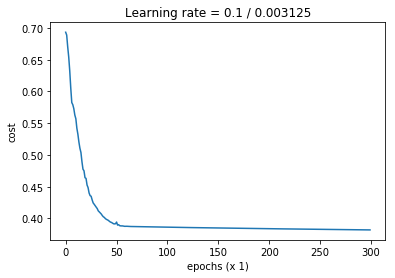

c_model: train accuracy: 86.0%
c_model: val accuracy = 82.0%
c_model: val error = 32.0 examples


,acc_train,acc_val,batch_size,lambda,layer_dims,learning_rate,min_lr,num_epochs,val_error
0,0.86,0.82,712,5.0,"[27, 7, 7, 1]",0.1,1.000000e-07,300,32.0


In [86]:
# Create an instance of the Custom_model class with 'layer_dims' architecture:
c_model = Custom_model(layer_dims)

# Set hyperparameters that we want to tune for the custom model:
lr              = 1e-1       # the learning rate for the gradient descent
min_lr          = 1e-7       # the lower threshold of the learning rate decay
optimizer       = 'adam'
batch_size      = m_train   
num_epochs      = 300          
lambd           = 5e+0          # lambda - regularization hyperparameter, scalar

# Train the model at various hyperparameters settings:
c_model.fit(X_train, Y_train, batch_size=batch_size, num_epochs=num_epochs, 
            lr=lr, lambd=lambd, optimizer=optimizer, print_cost=True)       

# Evaluation on the train data:
predict_train = c_model.predict(X_train)
c_train_acc = round(np.sum(predict_train == Y_train)/m_train, 2)

# Evaluation on the validation data:
predict_val = c_model.predict(X_val)
c_val_acc = round(np.sum(predict_val == Y_val)/m_val, 2)

print(f"c_model: train accuracy: {c_train_acc * 100}%")
print(f"c_model: val accuracy = {c_val_acc * 100}%")
print(f'c_model: val error = {round((1 - c_val_acc) * m_val)} examples')

# Update the journal of hyperparameters tuning records
record = {'layer_dims'   : c_model.get_layer_dims(), 
          'acc_train'    : c_train_acc, 
          'acc_val'      : c_val_acc,
          'val_error'    : round((1 - c_val_acc) * m_val),
          'batch_size'   : batch_size,
          'num_epochs'   : num_epochs,
          'learning_rate': lr,
          'min_lr'       : min_lr,
          'lambda'       : lambd}

records_list.append(record)
journal = pd.DataFrame(records_list)   # saves records only when repeatedly running the current cell
journal

## Conclusion: we have looked "under the hood" of a fully connected network using a custom model with adjustable numbers of layers and their dimensions, L2 regularization and Adam optimization algotithm. Its performance is comparable to the Keras models.

## Great! We know how it works!

### 5. PREDICTION ON TEST DATA AND SUBMISSION FILE

Cost after epoch 0: 0.6932122882520786
Cost after epoch 20: 0.4279050968255544
Cost after epoch 40: 0.42291940999533884
Cost after epoch 60: 0.4189480912434038
Cost after epoch 80: 0.4168006559206742
Cost after epoch 100: 0.41505753925790523
Cost after epoch 120: 0.4135921208298934
Cost after epoch 140: 0.4124549456655315
Cost after epoch 160: 0.4115565979742332
Cost after epoch 180: 0.41082704291298283
Cost after epoch 200: 0.4101077529011638
Cost after epoch 220: 0.40937689773448926
Cost after epoch 240: 0.40862435626806526
Cost after epoch 260: 0.4078929227263127
Cost after epoch 280: 0.40714807047448265


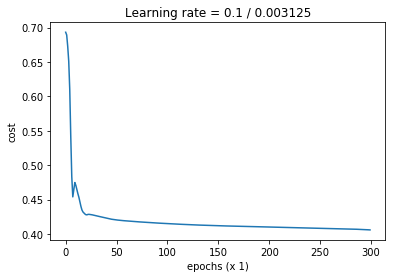

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [87]:
# Train the final model on all the data available with pretrained hyperparameters:
c_model_final = Custom_model(layer_dims)
X = np.concatenate((X_train, X_val), axis=1)
Y = np.concatenate((Y_train, Y_val), axis=1)
c_model_final.fit(X, Y, batch_size=(m_train + m_val), num_epochs=num_epochs, 
                  lr=lr, min_lr=min_lr, lambd=lambd, 
                  optimizer=optimizer, print_cost=True)

# Predict labels on the test dataset
prediction = c_model_final.predict(X_test)

# Save a submittion file with the predicted labels
submission = pd.DataFrame({"PassengerId": test_data["PassengerId"],
                           "Survived": np.squeeze(prediction)}).sort_values(by="PassengerId")
submission.to_csv("submission.csv", index=False)
submission.head()